In [1]:
import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/hg38/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '/media/ggj/FYT/CH/tmp/'

In [3]:
## read in sparse matrix, with features & barcodes respectively.
from scipy.io import mmread, mmwrite, mminfo
coo_mtx_path = '/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/hg38/matrix.mtx'
coo_mtx = mmread(coo_mtx_path)
mtx = coo_mtx.tocsr()


features = pd.read_csv('/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/hg38/features.csv', sep = ',', names = ['features'], dtype = 'str')
barcodes = pd.read_csv('/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/hg38/barcodes.csv', sep = ',', names = ['barcode'], dtype = 'str')

from pycisTopic.cistopic_class import *
cistopic_obj = create_cistopic_object(fragment_matrix = mtx, cell_names = barcodes['barcode'], region_names = features['features'])


## Adding cell information
cell_data = pd.read_csv('/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/hg38/metadata.csv', sep = ',', dtype= 'str')

cell_data.index = cistopic_obj.cell_data.index
cistopic_obj.add_cell_data(cell_data)

2023-04-04 12:07:41,115 cisTopic     INFO     Creating CistopicObject
2023-04-04 12:07:43,720 cisTopic     INFO     Done!


In [2]:
import ray
ray.init('auto')

2023-04-12 01:10:27,263	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.153.239:6379...
2023-04-12 01:10:27,272	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [ ]:
models = run_cgs_models(cistopic_obj, 
                       n_topics = [20,25,30,40],
                       n_cpu = 20,
                       n_iter = 200,
                       random_state = 555,
                       alpha = 50,
                       alpha_by_topic = True,
                       eta = 0.1,
                       eta_by_topic = False,
                       save_path = None,
                       _temp_dir = tmpDir)

2023-04-04 12:09:45,207	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


(run_cgs_model pid=33966) 2023-04-04 12:09:47,927 cisTopic     INFO     Running model with 20 topics
(run_cgs_model pid=33976) 2023-04-04 12:09:47,992 cisTopic     INFO     Running model with 25 topics
(run_cgs_model pid=33984) 2023-04-04 12:09:48,098 cisTopic     INFO     Running model with 30 topics
(run_cgs_model pid=33975) 2023-04-04 12:09:48,123 cisTopic     INFO     Running model with 40 topics


(raylet) [2023-04-04 12:09:54,193 E 33836 33860] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/CH/tmp/session_2023-04-04_12-09-41_938418_33196 is over 95% full, available space: 29923778560; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 12:10:04,232 E 33836 33860] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/CH/tmp/session_2023-04-04_12-09-41_938418_33196 is over 95% full, available space: 29923770368; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 12:10:14,273 E 33836 33860] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/CH/tmp/session_2023-04-04_12-09-41_938418_33196 is over 95% full, available space: 29923762176; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 12:10:24,314 E 33836 33860] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/CH/tmp/session_2023-04-04_12-09-41_938418_33196 is over 95% full, available spac

In [ ]:
import pickle
with open(outDir + 'CGS_models.pkl',  'wb') as f:
    pickle.dump(models, f)
    
from pycisTopic.lda_models import *    
model = evaluate_models(models, select_model = None, return_model = True, metrics = ['Arun_2010', 'Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'], plot_metrics = False, save = outDir + 'model_selection.pdf')


cistopic_obj.add_LDA_model(model)
with open(outDir + 'hg38_cistopicObject.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)
    
import pickle
infile = open(outDir + 'hg38_cistopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [ ]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj, 
             target = 'cell',
             k = 15,
             res = [0.3, 0.5, 0.7, 0.9],
             prefix = 'pycisTopic_',
             scale = True,
             split_pattern = '-')
             
run_umap(cistopic_obj, target = 'cell', scale = True)

visual_path = outDir + '/visualization'
if not os.path.exists(visual_path):
    os.mkdir(visual_path)
plot_metadata(cistopic_obj, 
             reduction_name = 'UMAP',
             variables = ['main_ct','pycisTopic_leiden_15_0.9'], 
             target = 'cell',  num_columns = 1,
             text_size = 10, dot_size = 5,
             figsize = (15,5),
             save = outDir + '/visualization/dimensionality_reduction_label.pdf')

cell_topic_heatmap(cistopic_obj, 
                  variables = ['main_ct'], 
                  scale = True, 
                  legend_loc_x = 1.05, 
                  legend_loc_y = -1.2, 
                  legend_dist_y = -1,
                  figsize = (10, 10), 
                  save = outDir + 'visualization/heatmap_topic_contr.pdf')
                  
with open(outDir + 'hg38_cluster_cistopicObject.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)

In [3]:
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import *  
from pycisTopic.clust_vis import *

import pickle
infile = open(outDir + 'hg38_cluster_cistopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

(raylet) [2023-04-04 14:40:21,815 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35242549248; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 14:40:31,838 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35242528768; capacity: 4000785100800. Object creation will fail if spilling is required.


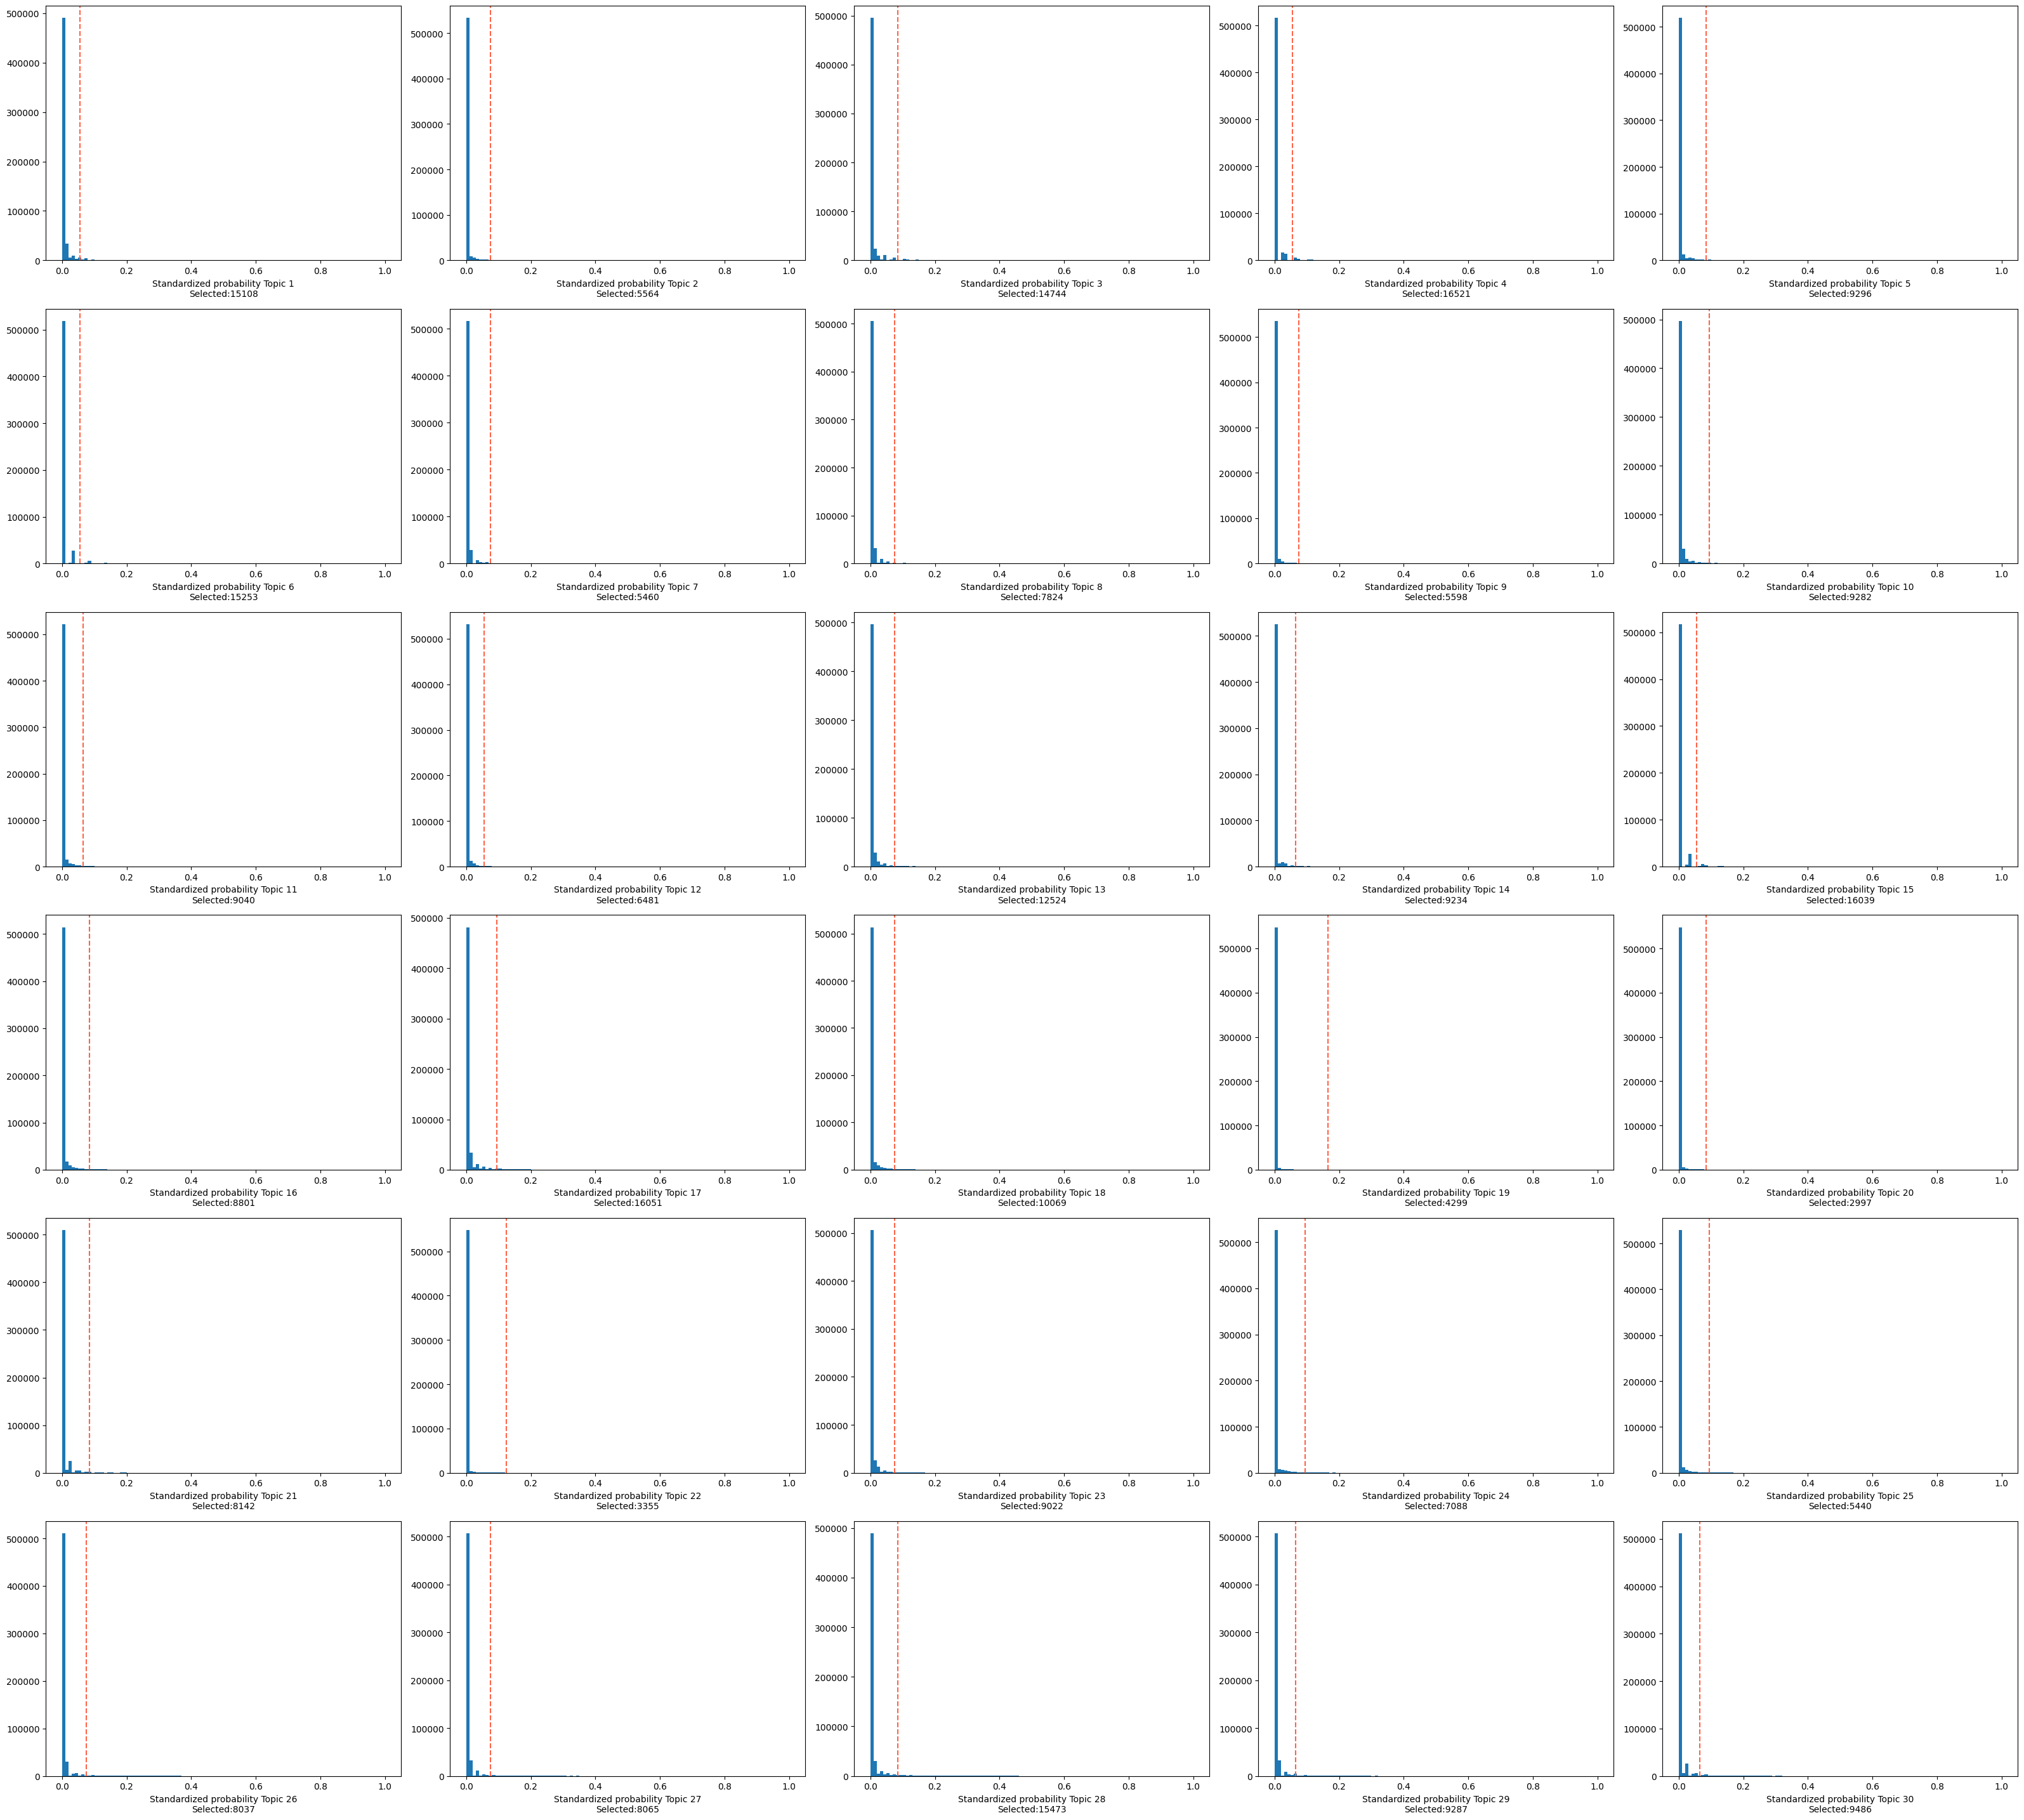

(raylet) [2023-04-04 14:40:41,864 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35242446848; capacity: 4000785100800. Object creation will fail if spilling is required.


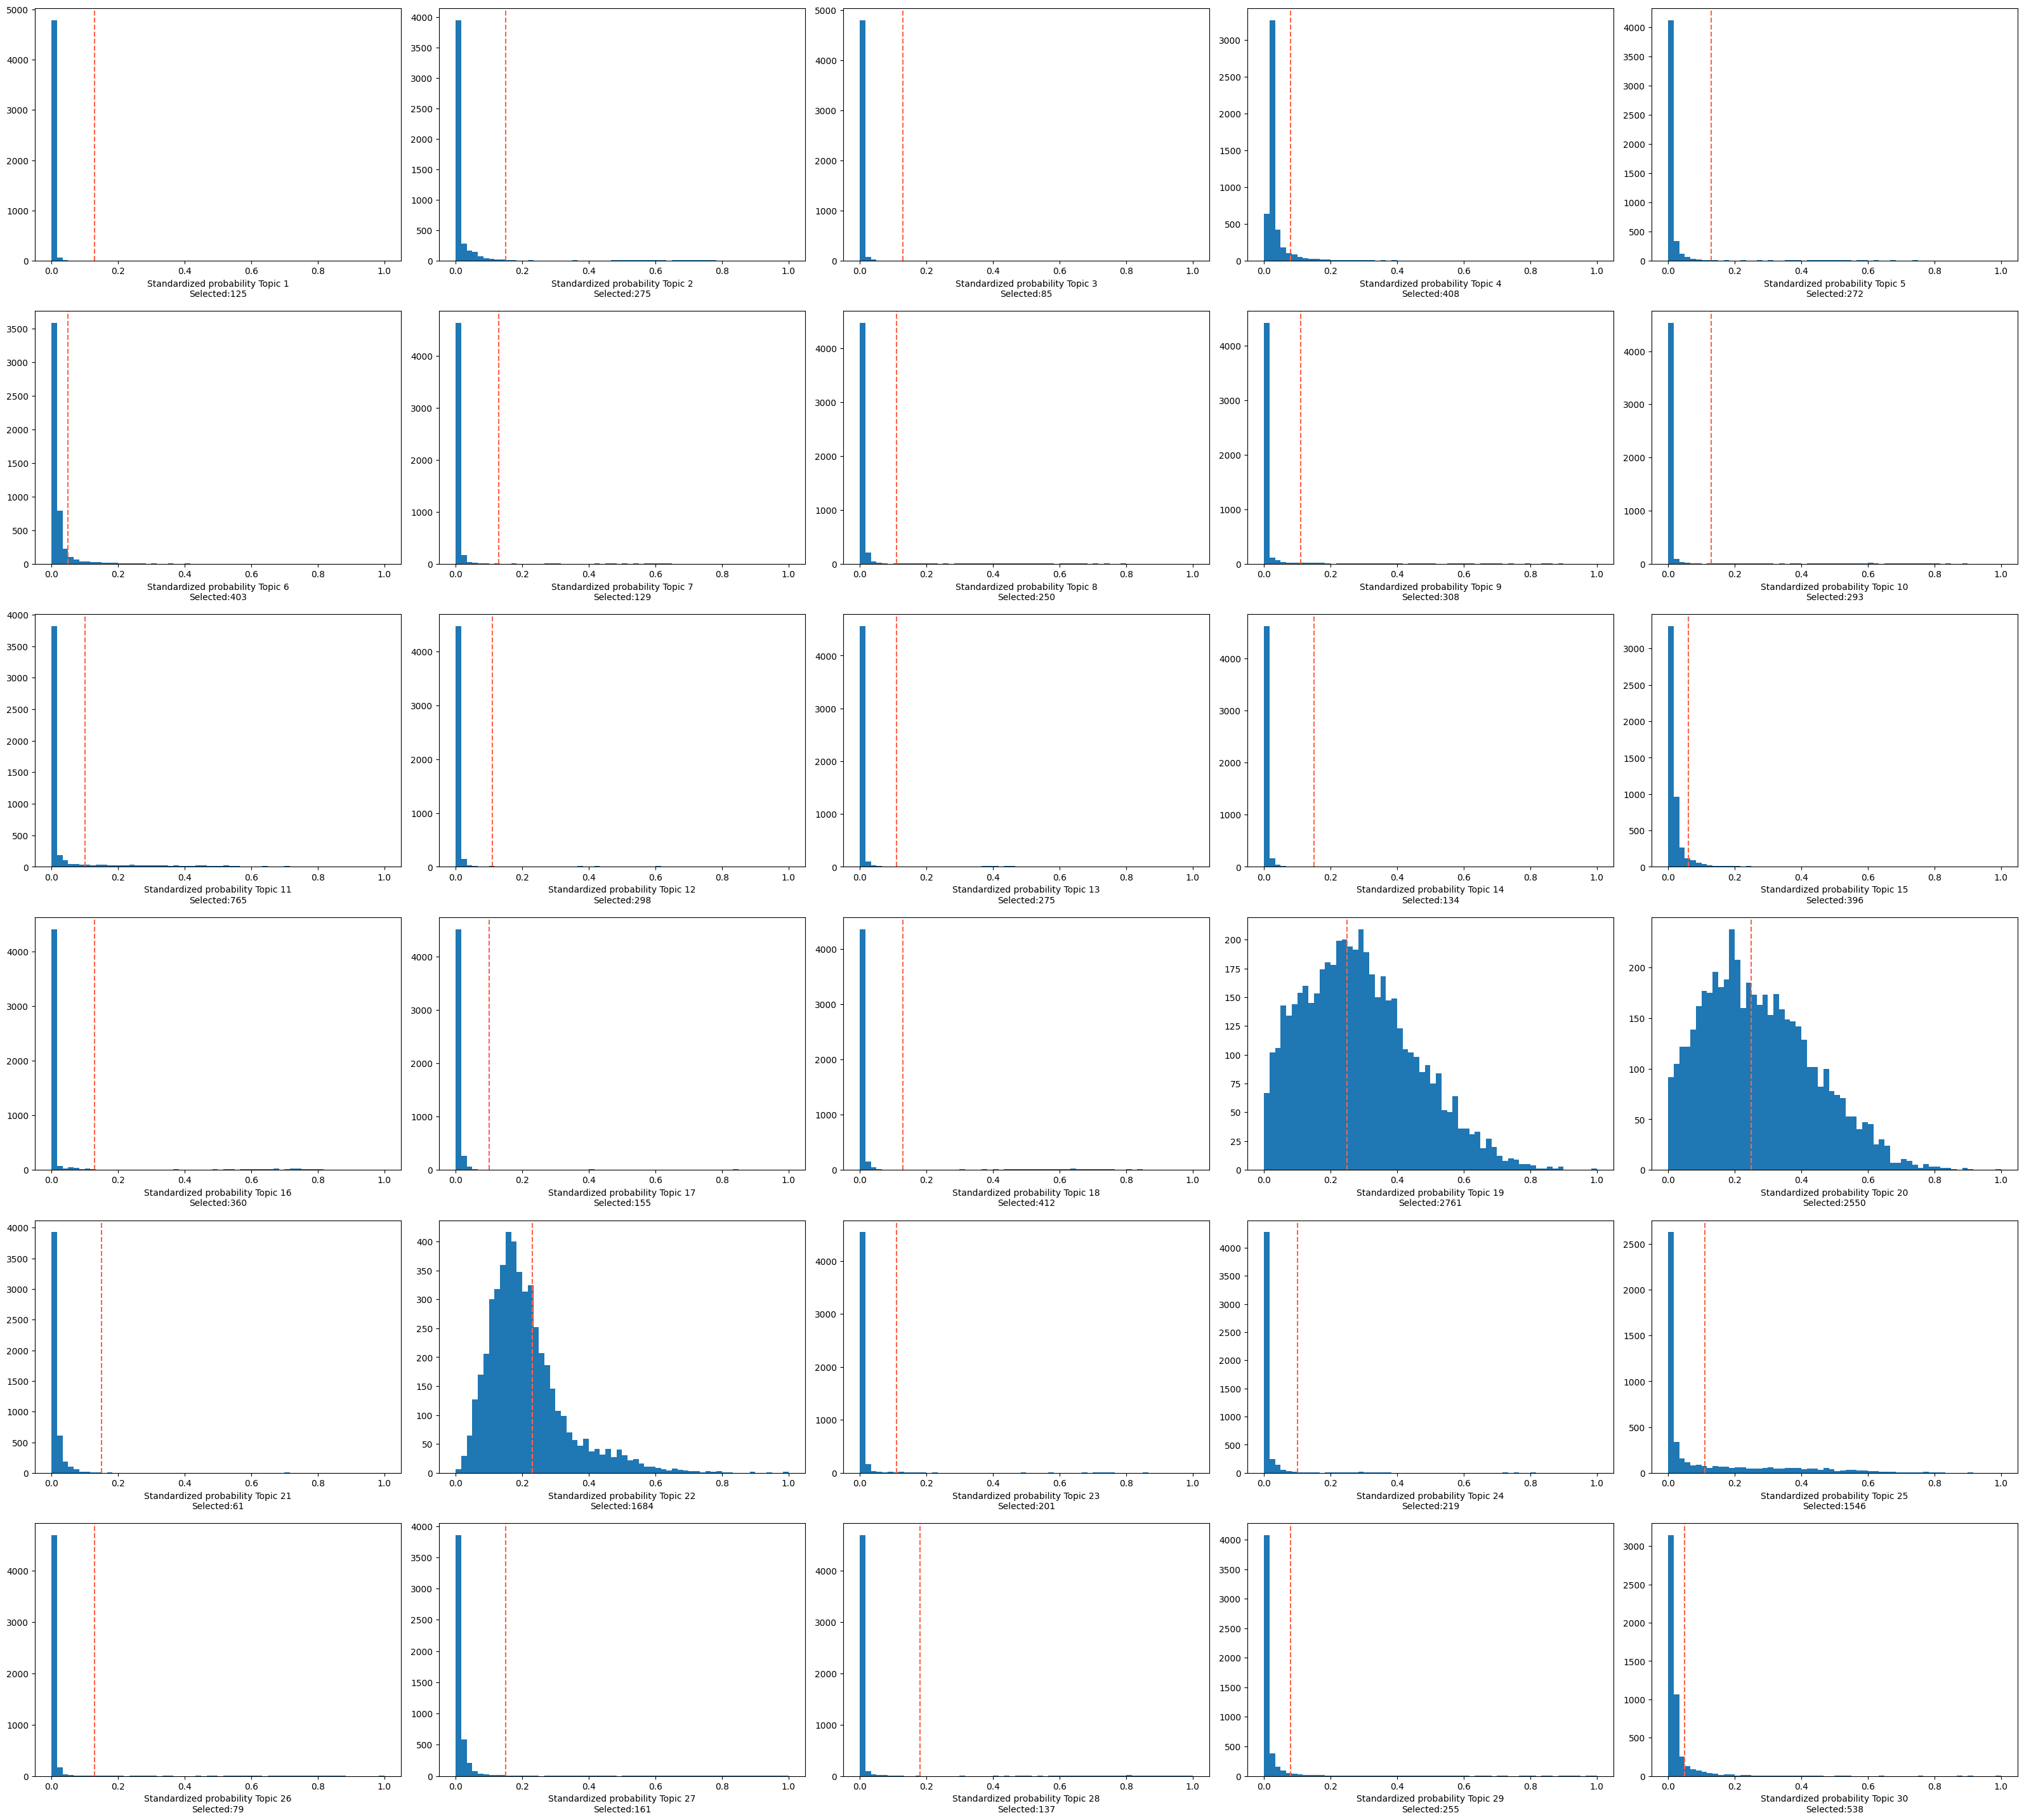

(raylet) [2023-04-04 14:40:51,889 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35242446848; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 14:41:01,911 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35242442752; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 14:41:11,935 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35242442752; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 14:41:21,959 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available 

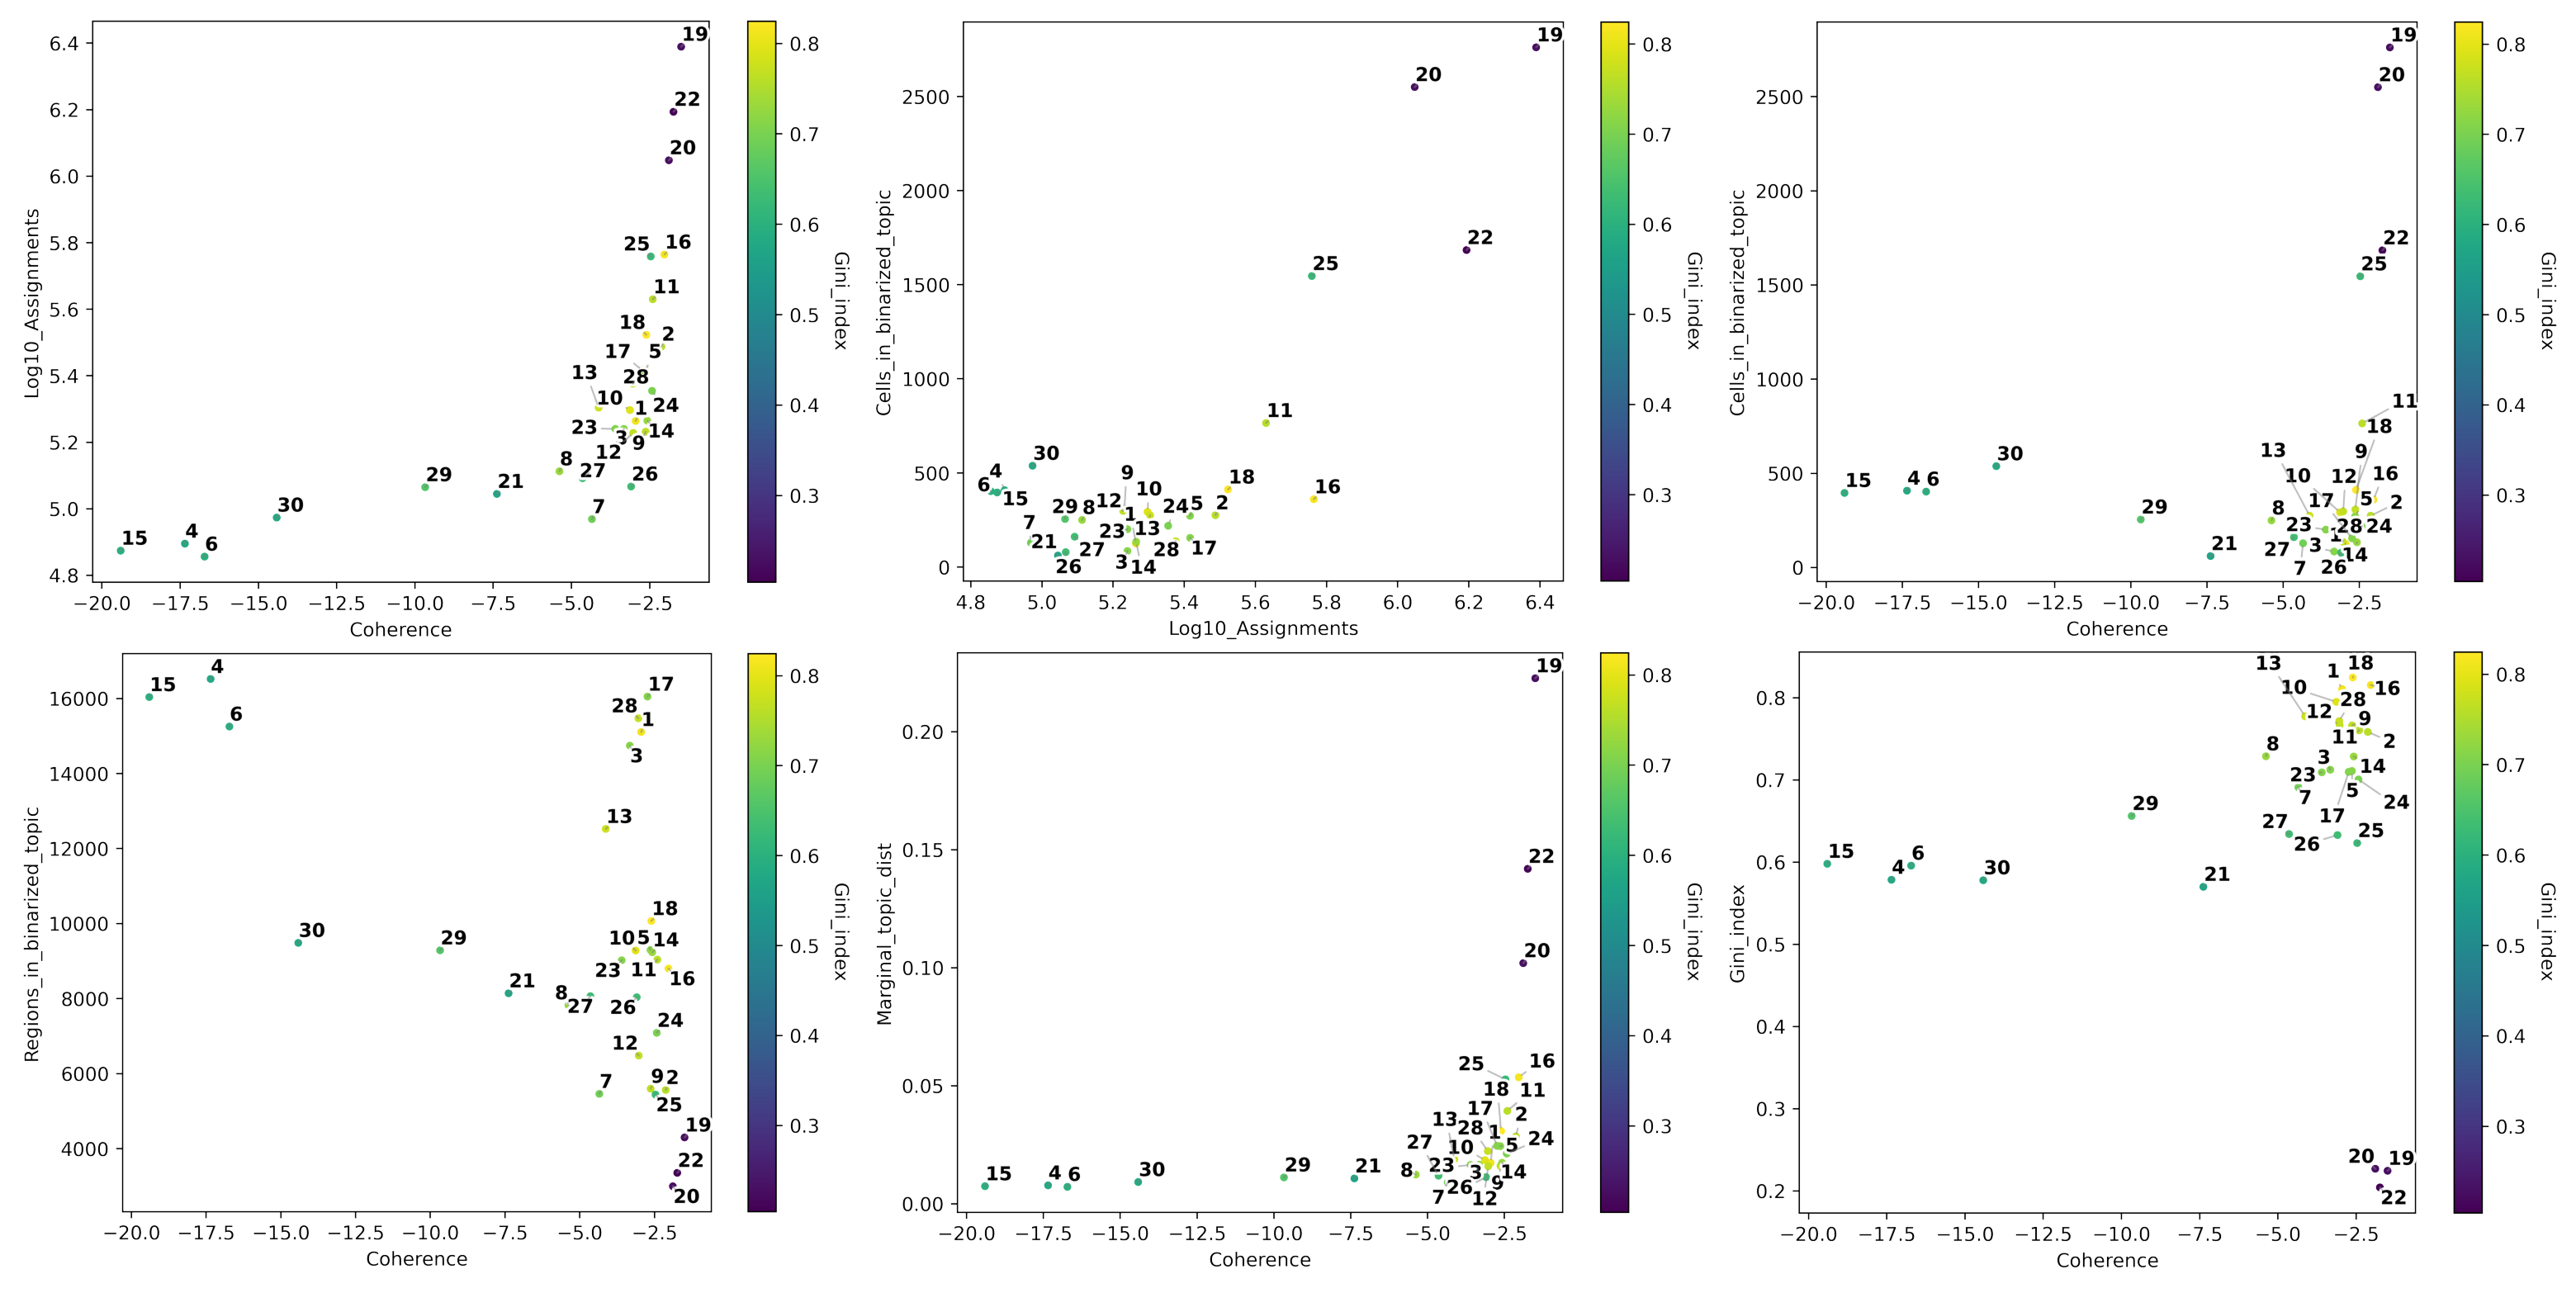

(raylet) [2023-04-04 14:41:42,014 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35233132544; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 14:41:52,043 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35233124352; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 14:42:02,084 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available space: 35231670272; capacity: 4000785100800. Object creation will fail if spilling is required.
(raylet) [2023-04-04 14:42:12,114 E 14594 14630] (raylet) file_system_monitor.cc:105: /media/ggj/FYT/tmp/ray/session_2023-04-04_14-36-29_109330_14253 is over 95% full, available 

In [8]:
#pycistopic
os.mkdir(outDir + 'topic_binarization')
from pycisTopic.topic_binarization import *
region_bin_topics = binarize_topics(cistopic_obj, method = 'otsu', ntop = 3000, plot = True, num_columns = 5, save = outDir + 'topic_binarization/otsu.pdf')

binarized_cell_topic = binarize_topics(cistopic_obj, target = 'cell', method = 'li', plot = True, num_columns = 5, nbins = 60)

## compute QC metrics.
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(outDir + 'topic_binarization/Topic_qc.pdf', bbox_inches='tight')
plt.show()

topic_annot = topic_annotation(cistopic_obj, annot_var='lineage', binarized_cell_topic=binarized_cell_topic, general_topic_thr = 0.2)

# Save
with open(outDir + 'topic_binarization/Topic_qc_metrics_annot.pkl', 'wb') as f:
    pickle.dump(topic_qc_metrics, f)
with open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'wb') as f:
    pickle.dump(binarized_cell_topic, f)
with open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'wb') as f:
    pickle.dump(region_bin_topics, f)
    

In [ ]:
#pycistarget DAR

In [4]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=cistopic_obj.region_names, scale_factor=10**6)

normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2023-04-11 22:21:37,485 cisTopic     INFO     Imputing drop-outs
2023-04-11 22:24:14,066 cisTopic     INFO     Scaling
2023-04-11 22:25:35,337 cisTopic     INFO     Keep non zero rows
2023-04-11 22:26:32,610 cisTopic     INFO     Imputed accessibility sparsity: 0.7106681750789865
2023-04-11 22:26:32,614 cisTopic     INFO     Create CistopicImputedFeatures object
2023-04-11 22:26:32,615 cisTopic     INFO     Making matrix sparse
2023-04-11 22:34:43,268 cisTopic     INFO     Done!
2023-04-11 22:34:44,055 cisTopic     INFO     Normalizing imputed data
2023-04-11 22:39:56,800 cisTopic     INFO     Done!


In [5]:
# Save
os.mkdir(outDir+'DARs')
with open(outDir + 'DARs/Imputed_accessibility.pkl', 'wb') as f:
    pickle.dump(imputed_acc_obj, f)

In [6]:
ray.shutdown()

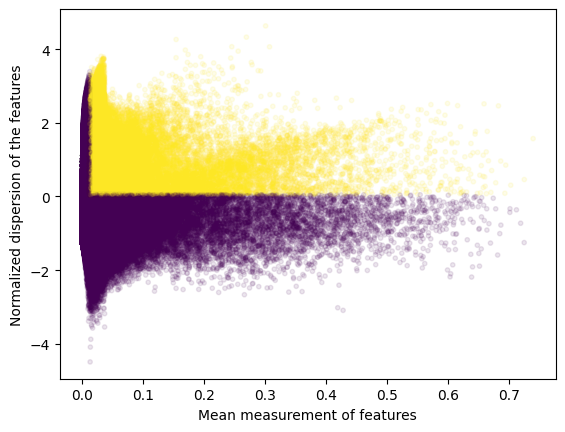

2023-04-11 23:31:06,053 cisTopic     INFO     Done!


In [7]:
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125,
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20,
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot.pdf')

In [9]:
with open(outDir + 'DARs/variable_regions.pkl', 'wb') as f:
    pickle.dump(variable_regions, f)

In [4]:
import pickle
infile = open(outDir + 'DARs/variable_regions.pkl', 'rb')
variable_regions= pickle.load(infile)
infile.close()

In [5]:
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb')
imputed_acc_obj= pickle.load(infile)
infile.close()

In [7]:
from pycisTopic.diff_features import *
markers_dict= find_diff_features(cistopic_obj,
                      imputed_acc_obj,
                      variable='lineage',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=10,
                      _temp_dir=tmpDir + 'ray_spill',
                      split_pattern = '-',ignore_reinit_error=True)

x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

2023-04-12 01:00:43,874	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


(markers_ray pid=727683) 2023-04-12 01:00:48,397 cisTopic     INFO     Formatting data for Endothelial
(markers_ray pid=727682) 2023-04-12 01:00:50,477 cisTopic     INFO     Formatting data for Epithelial
(markers_ray pid=727864) 2023-04-12 01:00:53,470 cisTopic     INFO     Formatting data for Gut
(markers_ray pid=727863) 2023-04-12 01:00:55,765 cisTopic     INFO     Formatting data for Hepatocyte
(markers_ray pid=728099) 2023-04-12 01:00:59,484 cisTopic     INFO     Formatting data for Immune
(markers_ray pid=728098) 2023-04-12 01:01:01,728 cisTopic     INFO     Formatting data for Muscle
(markers_ray pid=728313) 2023-04-12 01:01:05,452 cisTopic     INFO     Formatting data for Neural
(markers_ray pid=727683) 2023-04-12 01:01:11,750 cisTopic     INFO     Computing p-value for Endothelial
(markers_ray pid=727864) 2023-04-12 01:01:16,557 cisTopic     INFO     Computing p-value for Gut
(markers_ray pid=727682) 2023-04-12 01:01:21,797 cisTopic     INFO     Computing p-value for Epithelia

(raylet) Spilled 12003 MiB, 2 objects, write throughput 548 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


(markers_ray pid=728313) 2023-04-12 01:01:29,445 cisTopic     INFO     Computing p-value for Neural
(markers_ray pid=727863) 2023-04-12 01:01:30,223 cisTopic     INFO     Computing p-value for Hepatocyte


(raylet) Spilled 24005 MiB, 3 objects, write throughput 906 MiB/s.


(markers_ray pid=728098) 2023-04-12 01:01:36,336 cisTopic     INFO     Computing p-value for Muscle
(markers_ray pid=728099) 2023-04-12 01:01:37,897 cisTopic     INFO     Computing p-value for Immune
(markers_ray pid=727683) 2023-04-12 01:04:09,395 cisTopic     INFO     Computing log2FC for Endothelial
(markers_ray pid=727864) 2023-04-12 01:04:10,553 cisTopic     INFO     Computing log2FC for Gut
(markers_ray pid=727683) 2023-04-12 01:04:15,118 cisTopic     INFO     Endothelial done!
(markers_ray pid=727683) 2023-04-12 01:04:15,207 cisTopic     INFO     Formatting data for Renal


(raylet) Spilled 24006 MiB, 4 objects, write throughput 905 MiB/s.


(markers_ray pid=727864) 2023-04-12 01:04:15,994 cisTopic     INFO     Gut done!
(markers_ray pid=727864) 2023-04-12 01:04:16,114 cisTopic     INFO     Formatting data for Stromal
(markers_ray pid=727682) 2023-04-12 01:04:17,595 cisTopic     INFO     Computing log2FC for Epithelial
(markers_ray pid=727863) 2023-04-12 01:04:18,531 cisTopic     INFO     Computing log2FC for Hepatocyte
(markers_ray pid=727682) 2023-04-12 01:04:23,052 cisTopic     INFO     Epithelial done!


(raylet) Spilled 24011 MiB, 8 objects, write throughput 905 MiB/s.


(markers_ray pid=727863) 2023-04-12 01:04:23,786 cisTopic     INFO     Hepatocyte done!
(markers_ray pid=728313) 2023-04-12 01:04:23,971 cisTopic     INFO     Computing log2FC for Neural
(markers_ray pid=728313) 2023-04-12 01:04:29,396 cisTopic     INFO     Neural done!
(markers_ray pid=728098) 2023-04-12 01:04:30,257 cisTopic     INFO     Computing log2FC for Muscle
(markers_ray pid=727683) 2023-04-12 01:04:34,873 cisTopic     INFO     Computing p-value for Renal
(markers_ray pid=728098) 2023-04-12 01:04:35,893 cisTopic     INFO     Muscle done!
(markers_ray pid=728099) 2023-04-12 01:04:37,604 cisTopic     INFO     Computing log2FC for Immune
(markers_ray pid=727864) 2023-04-12 01:04:41,257 cisTopic     INFO     Computing p-value for Stromal
(markers_ray pid=728099) 2023-04-12 01:04:43,449 cisTopic     INFO     Immune done!
(markers_ray pid=727683) 2023-04-12 01:07:19,865 cisTopic     INFO     Computing log2FC for Renal
(markers_ray pid=727683) 2023-04-12 01:07:25,387 cisTopic     INF

In [8]:
#save
with open(outDir + 'DARs/DARs.pkl', 'wb') as f:
    pickle.dump(markers_dict, f)

In [3]:
import pickle
#infile = open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'rb')
#binarized_topic_region = pickle.load(infile)
#infile.close()

import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

In [ ]:
#pycistarget motif

In [10]:
ray.shutdown()

In [11]:
import ray
ray.init('auto')

2023-04-12 01:14:05,782	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.153.239:6379...
2023-04-12 01:14:05,787	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [12]:
# format region sets
import re
import pyranges as pr
from pycistarget.utils import *
region_sets = {}
#region_sets['Topics'] = {key : pr.PyRanges(region_names_to_coordinates(binarized_topic_region[key].index.tolist())) for key in binarized_topic_region.keys()}
region_sets['DARs'] = {re.sub('[^A-Za-z0-9]+', '_', key): pr.PyRanges(region_names_to_coordinates(DARs_dict[key].index.tolist())) for key in DARs_dict.keys()}

# Run pycistarget
# run_without_promoters = True, will run the methods in all regions + the region sets without promoters
savepath = outDir + 'pycisTarget/'
if not os.path.exists(savepath):
    os.mkdir(savepath)

import os
from scenicplus.wrappers.run_pycistarget import *
run_pycistarget(region_sets,
                 ctx_db_path = '/media/ggj/Guo-4T-AI/Scenicplus_database/hg38_screen_v10_clust.regions_vs_motifs.rankings.feather',
                 species = 'hsapiens',
                 save_path = savepath,
                 run_without_promoters = False,
                 biomart_host = 'http://www.ensembl.org',
                 promoter_space = 500,
                 ctx_auc_threshold = 0.005,
                 ctx_nes_threshold = 3.0,
                 ctx_rank_threshold = 0.05,
                 dem_log2fc_thr = 0.5,
                 dem_motif_hit_thr = 3.0,
                 dem_max_bg_regions = 500,
                 n_cpu = 16,
                 _temp_dir = tmpDir,
               ignore_reinit_error=True,
               path_to_motif_annotations = '/media/ggj/Guo-4T-AI/Scenicplus_database/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl',
               annotation_version = 'v10nr_clust',
               annotation = ['Direct_annot', 'Orthology_annot'])

2023-04-12 01:14:07,041 pycisTarget_wrapper INFO     /media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/hg38/output/pycisTarget/ folder already exists.
2023-04-12 01:14:07,487 pycisTarget_wrapper INFO     Loading cisTarget database for DARs
2023-04-12 01:14:07,489 cisTarget    INFO     Reading cisTarget database
2023-04-12 01:17:50,478 pycisTarget_wrapper INFO     Running cisTarget for DARs
(ctx_internal_ray pid=730474) 2023-04-12 01:17:52,668 cisTarget    INFO     Running cisTarget for Endothelial which has 12557 regions
(ctx_internal_ray pid=730473) 2023-04-12 01:17:52,755 cisTarget    INFO     Running cisTarget for Epithelial which has 18520 regions
(ctx_internal_ray pid=730641) 2023-04-12 01:17:53,758 cisTarget    INFO     Running cisTarget for Gut which has 18580 regions
(ctx_internal_ray pid=730640) 2023-04-12 01:17:53,712 cisTarget    INFO     Running cisTarget for Hepatocyte which has 17277 regions
(ctx_internal_ray pid=730809) 2023-04-12 01:17:54,875 cisTarget    INFO     Running cisT